In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

In [4]:
print(tf.__version__)

2.12.0


# Auto MPG 데이터셋

## 데이터 구하기

In [5]:
dataset_path = keras.utils.get_file(fname="auto-mpg.data", 
                                    origin="http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

30286/30286 [==============================] - 0s 5us/step


In [7]:
dataset_path

'/Users/rainmaker/.keras/datasets/auto-mpg.data'

In [8]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']

In [9]:
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)

In [10]:
dataset = raw_dataset.copy()

In [11]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


## 데이터 정제하기

In [13]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [14]:
dataset = dataset.dropna()

## Origin 컬럼 One-Hot Encoding

In [15]:
origin = dataset.pop('Origin')

In [16]:
origin.value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [17]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

In [18]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 데이터셋을 훈련 세트와 테스트 세트로 분할하기

In [19]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 데이터 조사하기

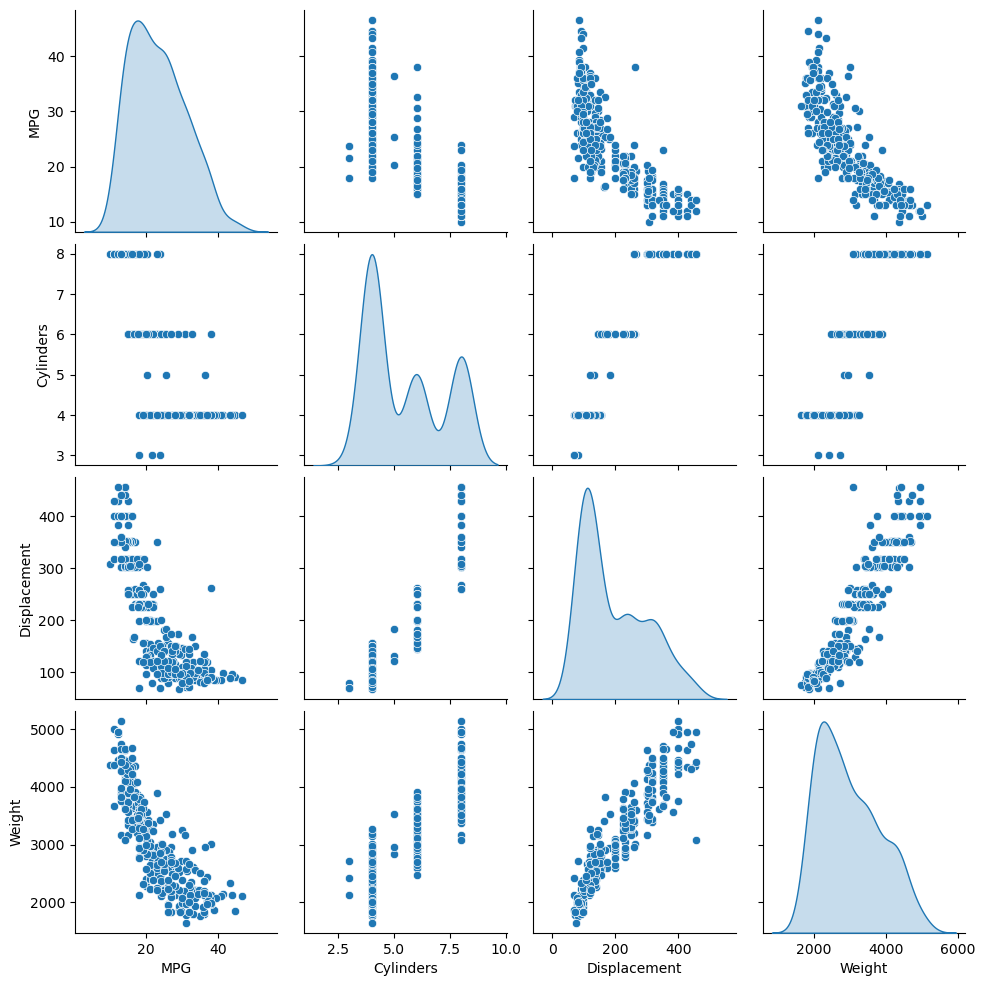

In [20]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']], diag_kind="kde")
plt.show()

In [21]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 특성과 레이블을 분리하기

In [22]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [23]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## 데이터 정규화

- 특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장
- 특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어짐
- 하기 예시는 의도적으로 훈련 세트만 사용하여 통계치를 생성하였음
- 이 통계는 테스트 세트를 정규화할 때에도 사용됨
- 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서임

In [24]:
def norm(x):
    return (x - train_stats["mean"] / train_stats['std'])

In [25]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [26]:
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,0.777417,88.127907,72.247248,2121.456622,8.921673,53.351069,-0.286751,-0.465148,-0.495225
282,0.777417,138.127907,85.247248,2886.456622,11.721673,58.351069,-0.286751,-0.465148,-0.495225
69,4.777417,348.127907,157.247248,4452.456622,7.921673,51.351069,-0.286751,-0.465148,-0.495225
378,0.777417,103.127907,60.247248,2121.456622,9.121673,61.351069,-0.286751,-0.465148,-0.495225
331,0.777417,95.127907,64.247248,2141.456622,12.421673,59.351069,-1.286751,-0.465148,0.504775


In [27]:
normed_test_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,4.777417,388.127907,187.247248,3846.456622,2.921673,49.351069,-0.286751,-0.465148,-0.495225
25,4.777417,358.127907,212.247248,4611.456622,8.421673,49.351069,-0.286751,-0.465148,-0.495225
28,4.777417,302.127907,190.247248,4728.456622,12.921673,49.351069,-0.286751,-0.465148,-0.495225
31,0.777417,111.127907,92.247248,2224.456622,8.421673,50.351069,-1.286751,-0.465148,0.504775
33,2.777417,230.127907,97.247248,2630.456622,7.421673,50.351069,-0.286751,-0.465148,-0.495225


# 모델

## 모델 만들기

In [28]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [29]:
def build_model():
    model = keras.models.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    return model

In [30]:
model = build_model()

## 모델 확인

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [32]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 109ms/step


array([[-201.10922],
       [-276.54532],
       [-420.0987 ],
       [-202.96097],
       [-204.19644],
       [-307.4065 ],
       [-187.44226],
       [-317.5301 ],
       [-295.9519 ],
       [-214.11122]], dtype=float32)

## 모델 훈련

In [33]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

In [34]:
EPOCHS=1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [35]:
for key in history.history.keys():
    print(f"key: {key}")

key: loss
key: mae
key: mse
key: val_loss
key: val_mae
key: val_mse


In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,12.988105,2.744686,12.988105,11.856721,2.685692,11.856721,995
996,13.267107,2.817575,13.267107,16.461304,3.301238,16.461304,996
997,10.239035,2.437191,10.239035,10.156299,2.376096,10.156299,997
998,14.675200,2.936863,14.675200,13.347596,2.863045,13.347596,998
999,12.903868,2.732591,12.903868,9.526732,2.319384,9.526732,999


In [37]:
import matplotlib.pyplot as plt

In [38]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.plot(hist['epoch'], hist['mae'], label='Training Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    #plt.ylim([0, 5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(hist['epoch'], hist['mse'], label='Training Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MPG]')
    #plt.ylim([0, 20])
    plt.legend()
    
    plt.show()

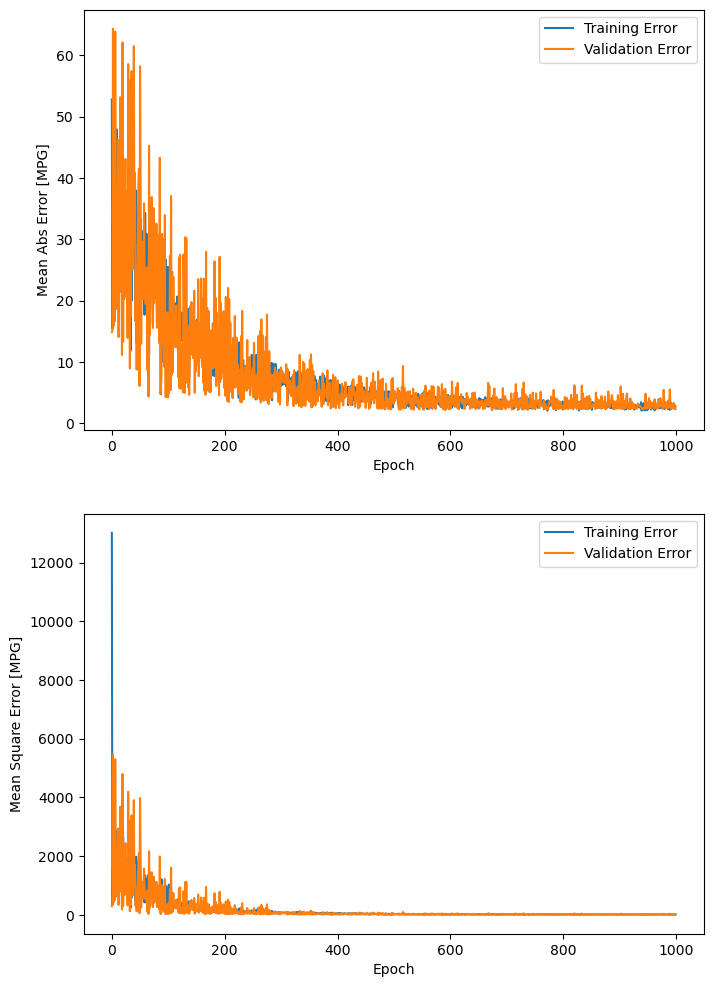

In [39]:
plot_history(history)

In [40]:
model = build_model()

In [41]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [42]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, 
                    callbacks=[early_stop, PrintDot()])


..........................

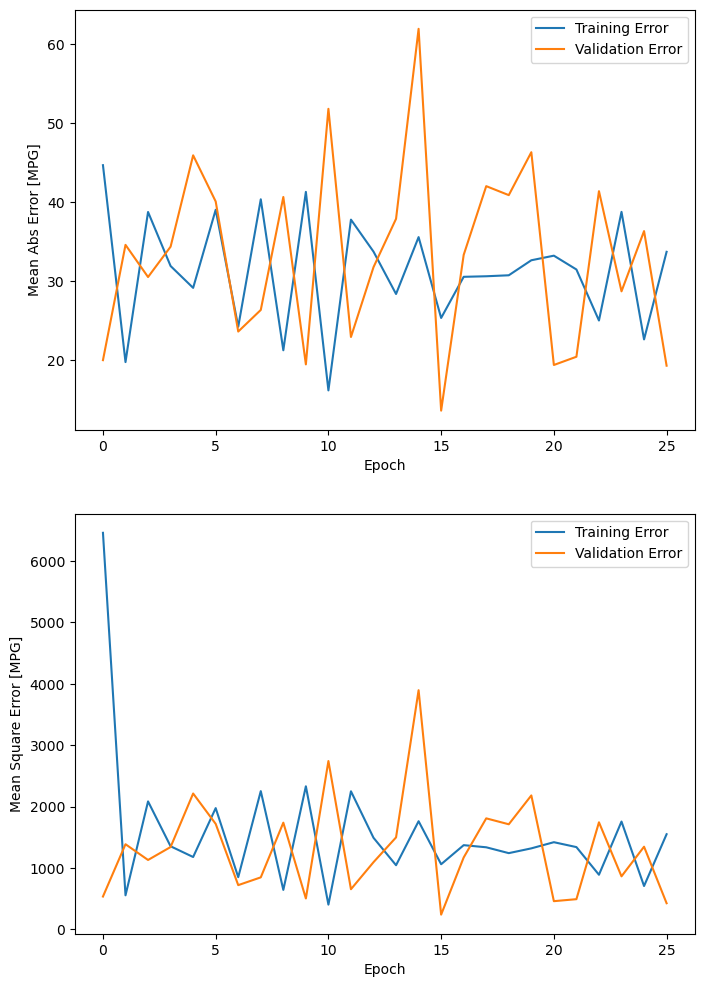

In [43]:
plot_history(history)

In [44]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

3/3 - 0s - loss: 422.8171 - mae: 19.2790 - mse: 422.8171 - 27ms/epoch - 9ms/step


In [45]:
print("테스트 데이터셋의 평균 절대 오차: {:5.2f} MPG".format(mae))

테스트 데이터셋의 평균 절대 오차: 19.28 MPG


# 예측

In [46]:
test_predictions = model.predict(normed_test_data).flatten()

3/3 [==============================] - 0s 2ms/step


In [47]:
test_predictions

array([5.806761  , 2.9566631 , 0.71423143, 5.2040157 , 6.6359844 ,
       3.3792248 , 3.243742  , 1.7751293 , 4.1912518 , 6.1574497 ,
       4.9492016 , 2.6241055 , 1.8062267 , 4.373724  , 4.562895  ,
       2.4835186 , 4.4736767 , 2.6086254 , 5.649557  , 2.4962597 ,
       5.5737286 , 5.420019  , 2.510725  , 3.6078777 , 5.426962  ,
       4.101553  , 1.2992687 , 4.5415325 , 3.8009472 , 5.108206  ,
       4.992544  , 2.8659878 , 4.143751  , 1.5077343 , 4.901396  ,
       1.9956646 , 5.3086834 , 5.257429  , 5.879736  , 1.5599651 ,
       5.725256  , 5.3598614 , 4.254698  , 6.0773525 , 7.0733166 ,
       5.2765102 , 4.087202  , 3.941801  , 7.335417  , 5.2117825 ,
       5.0432034 , 3.3493938 , 5.6165066 , 5.3981    , 5.1782513 ,
       6.102949  , 6.4449673 , 5.9372616 , 3.8746014 , 5.2224255 ,
       5.794607  , 5.5888653 , 5.645529  , 6.2053127 , 6.0690594 ,
       7.0692196 , 6.737158  , 6.3765163 , 5.9453793 , 1.686369  ,
       4.586607  , 6.8729687 , 4.9970684 , 6.1885204 , 7.58923

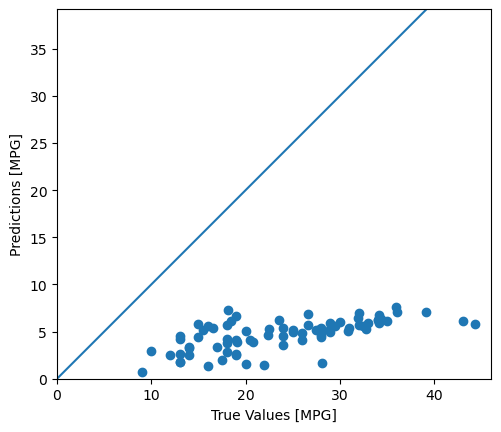

In [48]:
plt.scatter(x=test_labels, y=test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100],[-100, 100])

In [49]:
error = test_predictions - test_labels

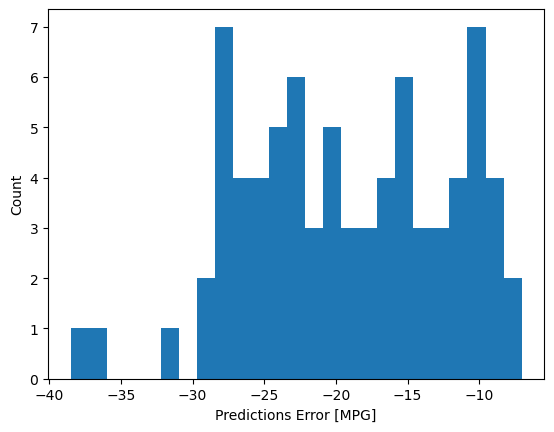

In [50]:
plt.hist(error, bins = 25)
plt.xlabel('Predictions Error [MPG]')
_ = plt.ylabel('Count')

# 결론

1. 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
2. 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
3. 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
4. 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
5. 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.